# MICCoM School 2017 Ex#4 : Parallelization

We are going to explain the parallelization levels present in WEST.

## 4.1 Download the material

In this excercixe we will focus on the `wstat.x` input.

In [1]:
# pseudopotentials
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/Si_ONCV_PBE-1.2.upf
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf

# input files
!wget -N -q http://www.west-code.org/doc/training/silane/pw.in
!wget -N -q http://www.west-code.org/doc/training/silane/wstat.in

We need to read the output of a DFT calculation, therefore as first step we run the DFT calculation invoking the executable `pw.x` on 8 cores.

In [ ]:
!mpirun -n 8 pw.x -i pw.in > pw.out

## 5.2 Parallelization schemes in WEST

WEST uses up to four layers of parallelism on CPU-based computers:

- Plane-waves (FFT)
- Bands
- Spin channels
- Eigenpotentials

The following command is using `N` CPU cores, `NI` images, `NK` pools, `NB` band groups, and `N/(NI*NK*NB)` cores per FFT:

```
mpirun -n N wstat.x -nimage NI -npool NK -nbgrp NB -i wstat.in > wstat.out
```

This is how we achieved good scaling on CPU-based supercomputers such as the BG/Q Mira at Argonne National Laboratory, where WEST makes efficient use of 512 cores per FFT and 1024 images, for a total of N = 512 $\times$ 1024 = 524288 cores.

Details about the implementation are described in [J. Chem. Theory Comput. 11, 2680 (2015)](https://pubs.acs.org/doi/full/10.1021/ct500958p#showFigures).

<img src="https://pubs.acs.org/cms/10.1021/ct500958p/asset/images/medium/ct-2014-00958p_0005.gif" width="50%">

On computers equipped with GPU accelerators, WEST is capable of harnessing the data parallelism provided by GPUs. Again, we achieved good scaling on GPU-accelerated supercomputers such as Summit at Oak Ridge National Laboratory, where WEST makes efficient use of over 25000 NVIDIA V100 GPUs.
Details about the implementation are described in [J. Chem. Theory Comput. 18, 4690-4707 (2022)](https://pubs.acs.org/doi/10.1021/acs.jctc.2c00241).

In [ ]:
!export OMP_NUM_THREADS=1

!mpirun -n 2 wstat.x -nimage 1 -i wstat.in > wstat.out
!mv silane.wstat.save/wstat.json wstat_cores2_image1.json

!mpirun -n 4 wstat.x -nimage 1 -i wstat.in > wstat.out
!mv silane.wstat.save/wstat.json wstat_cores4_image1.json

!mpirun -n 4 wstat.x -nimage 2 -i wstat.in > wstat.out
!mv silane.wstat.save/wstat.json wstat_cores4_image2.json

!mpirun -n 8 wstat.x -nimage 1 -i wstat.in > wstat.out
!mv silane.wstat.save/wstat.json wstat_cores8_image1.json

!mpirun -n 8 wstat.x -nimage 2 -i wstat.in > wstat.out
!mv silane.wstat.save/wstat.json wstat_cores8_image2.json

!mpirun -n 8 wstat.x -nimage 4 -i wstat.in > wstat.out
!mv silane.wstat.save/wstat.json wstat_cores8_image4.json

In [2]:
!ls -lrt wstat_*json

-rw-r--r--  1 vwzyu  staff  22533 Oct  7 12:56 wstat_cores2_image1.json
-rw-r--r--  1 vwzyu  staff  22540 Oct  7 12:56 wstat_cores4_image1.json
-rw-r--r--  1 vwzyu  staff  22520 Oct  7 12:56 wstat_cores4_image2.json
-rw-r--r--  1 vwzyu  staff  22652 Oct  7 12:56 wstat_cores8_image1.json
-rw-r--r--  1 vwzyu  staff  22552 Oct  7 12:56 wstat_cores8_image2.json
-rw-r--r--  1 vwzyu  staff  22523 Oct  7 12:56 wstat_cores8_image4.json


Load the files.

In [3]:
import json

data = {}

for name in ['cores2_image1', 'cores4_image1', 'cores4_image2', 'cores8_image1', 'cores8_image2', 'cores8_image4'] :
    # read data wstat_XX.json
    with open('wstat_'+name+'.json', 'r') as file:
        data[name] = json.load(file)

print(json.dumps(data, indent=2))

{
  "cores2_image1": {
    "runjob": {
      "startdate": " 7Oct2022",
      "starttime": "12:51:41",
      "completed": true,
      "endtime": "12:52:46",
      "enddate": " 7Oct2022"
    },
    "software": {
      "package": "WEST",
      "program": "WSTAT",
      "version": "5.2.0",
      "westgit": "v5.2.0-4-ga2c3fe0",
      "website": "http://www.west-code.org",
      "citation": "M. Govoni et al., J. Chem. Theory Comput. 11, 2680 (2015).",
      "qeversion": "7.1"
    },
    "config": {
      "io": {
        "islittleendian": true
      }
    },
    "parallel": {
      "nranks": 2,
      "nimage": 1,
      "npool": 1,
      "nbgrp": 1,
      "nrg": 2,
      "nproc": 2,
      "nthreads": 1
    },
    "input": {
      "input_west": {
        "qe_prefix": "silane",
        "west_prefix": "silane",
        "outdir": "./"
      },
      "wstat_control": {
        "wstat_calculation": "S",
        "n_pdep_eigen": 50,
        "n_pdep_times": 4,
        "n_pdep_maxiter": 100,
        "n_

We plot the energy levels of DFT and GW.

{'cores2_image1': [65.05135607719421], 'cores4_image1': [26.63409113883972], 'cores4_image2': [25.37000799179077], 'cores8_image1': [19.94772696495056], 'cores8_image2': [19.21418809890747], 'cores8_image4': [8.456115007400513]}


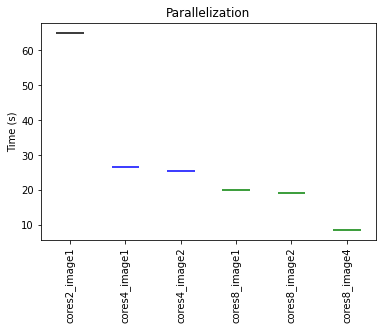

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# timings
y = {}
c = {}

# 2 cores
for name in ['cores2_image1'] :
    y[name] = [ data[name]['timing']['WSTAT']['wall:sec'] ]
    c[name] = 'black'

# 4 cores
for name in ['cores4_image1', 'cores4_image2'] :
    y[name] = [ data[name]['timing']['WSTAT']['wall:sec'] ]
    c[name] = 'blue'

# 8 cores
for name in ['cores8_image1','cores8_image2','cores8_image4'] :
    y[name] = [ data[name]['timing']['WSTAT']['wall:sec'] ]
    c[name] = 'green'

print(y)

# plot
x = list(range(1, len(y)+1))
labels = y.keys()

fig, ax = plt.subplots(1, 1)
counter = 0
for i in labels :
    for a in y[i] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[i])
    counter += 1

plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Time (s)')

plt.title('Parallelization')

plt.show()